# Read in data

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xesmf as xe
import xclim.sdba as sdba

## 1. Calculate the mean temperature based on tmax and tmin data

In [101]:
# open ERA5 data sample
tmax_1980 = xr.open_dataset("../Data/TerraClimate_Gridded_Obs_Geriza/tmax/TerraClimate.tmax.monthlymean.1980.nc")
tmax_1980

<xarray.Dataset> Size: 347kB
Dimensions:  (crs: 1, lon: 60, lat: 120, time: 12)
Coordinates:
  * crs      (crs) int16 2B 3
  * lon      (lon) float64 480B 32.02 32.06 32.1 32.15 ... 34.4 34.44 34.48
  * lat      (lat) float64 960B 15.98 15.94 15.9 15.85 ... 11.1 11.06 11.02
  * time     (time) datetime64[ns] 96B 1980-01-01 1980-02-01 ... 1980-12-01
Data variables:
    tmax     (time, lat, lon) float32 346kB ...
Attributes: (12/49)
    method:                          These layers from TerraClimate were crea...
    title:                           TerraClimate: monthly climate and climat...
    summary:                         This archive contains a dataset of high-...
    keywords:                        WORLDCLIM,global,monthly, temperature,pr...
    id:                              Blank
    naming_authority:                edu.uidaho.nkn
    ...                              ...
    geospatial_vertical_resolution:  0.0
    geospatial_vertical_positive:    Up
    references:                      Abatzoglou, J.T., S.Z. Dobrowski, S.A. P...
    source:                          WorldClim v2.0 (2.5m), CRU Ts4.0, JRA-55
    version:                         v1.0
    Conventions:                     CF-1.6

In [102]:
# Check the data
tmax_1980.tmax

<xarray.DataArray 'tmax' (time: 12, lat: 120, lon: 60)> Size: 346kB
[86400 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 480B 32.02 32.06 32.1 32.15 ... 34.4 34.44 34.48
  * lat      (lat) float64 960B 15.98 15.94 15.9 15.85 ... 11.1 11.06 11.02
  * time     (time) datetime64[ns] 96B 1980-01-01 1980-02-01 ... 1980-12-01
Attributes:
    units:              degC
    description:        Maximum 2-m Temperature
    long_name:          air_temperature
    standard_name:      air_temperature
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326
    _ChunkSizes:        [   1  720 1440]

In [103]:
# time, lat, lon
tmax_1980.tmax.shape

(12, 120, 60)

In [104]:
# select a region near western Europe
lats = [11, 16]
lons = [32, 34.5]

# convert longitude values in the dataset from the (0, 360) convention to the (-180, 180) convention
tmax_1980 = tmax_1980.assign_coords(lon = (((tmax_1980.lon + 180) % 360) - 180))
tmax_1980 = tmax_1980.sortby('lon')

# subset the data
ds_subset = tmax_1980.sel(lat = slice(*lats), lon = slice(*lons), time = tmax_1980.time.dt.year.isin(range(2071, 2101)))
ds_subset

<xarray.Dataset> Size: 482B
Dimensions:  (crs: 1, lat: 0, time: 0, lon: 60)
Coordinates:
  * crs      (crs) int16 2B 3
  * lat      (lat) float64 0B 
  * time     (time) datetime64[ns] 0B 
  * lon      (lon) float64 480B 32.02 32.06 32.1 32.15 ... 34.4 34.44 34.48
Data variables:
    tmax     (time, lat, lon) float32 0B ...
Attributes: (12/49)
    method:                          These layers from TerraClimate were crea...
    title:                           TerraClimate: monthly climate and climat...
    summary:                         This archive contains a dataset of high-...
    keywords:                        WORLDCLIM,global,monthly, temperature,pr...
    id:                              Blank
    naming_authority:                edu.uidaho.nkn
    ...                              ...
    geospatial_vertical_resolution:  0.0
    geospatial_vertical_positive:    Up
    references:                      Abatzoglou, J.T., S.Z. Dobrowski, S.A. P...
    source:                          WorldClim v2.0 (2.5m), CRU Ts4.0, JRA-55
    version:                         v1.0
    Conventions:                     CF-1.6

In [105]:
tmax_1980_t = tmax_1980["tmax"]
tmax_1980_t

<xarray.DataArray 'tmax' (time: 12, lat: 120, lon: 60)> Size: 346kB
[86400 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 960B 15.98 15.94 15.9 15.85 ... 11.1 11.06 11.02
  * time     (time) datetime64[ns] 96B 1980-01-01 1980-02-01 ... 1980-12-01
  * lon      (lon) float64 480B 32.02 32.06 32.1 32.15 ... 34.4 34.44 34.48
Attributes:
    units:              degC
    description:        Maximum 2-m Temperature
    long_name:          air_temperature
    standard_name:      air_temperature
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326
    _ChunkSizes:        [   1  720 1440]

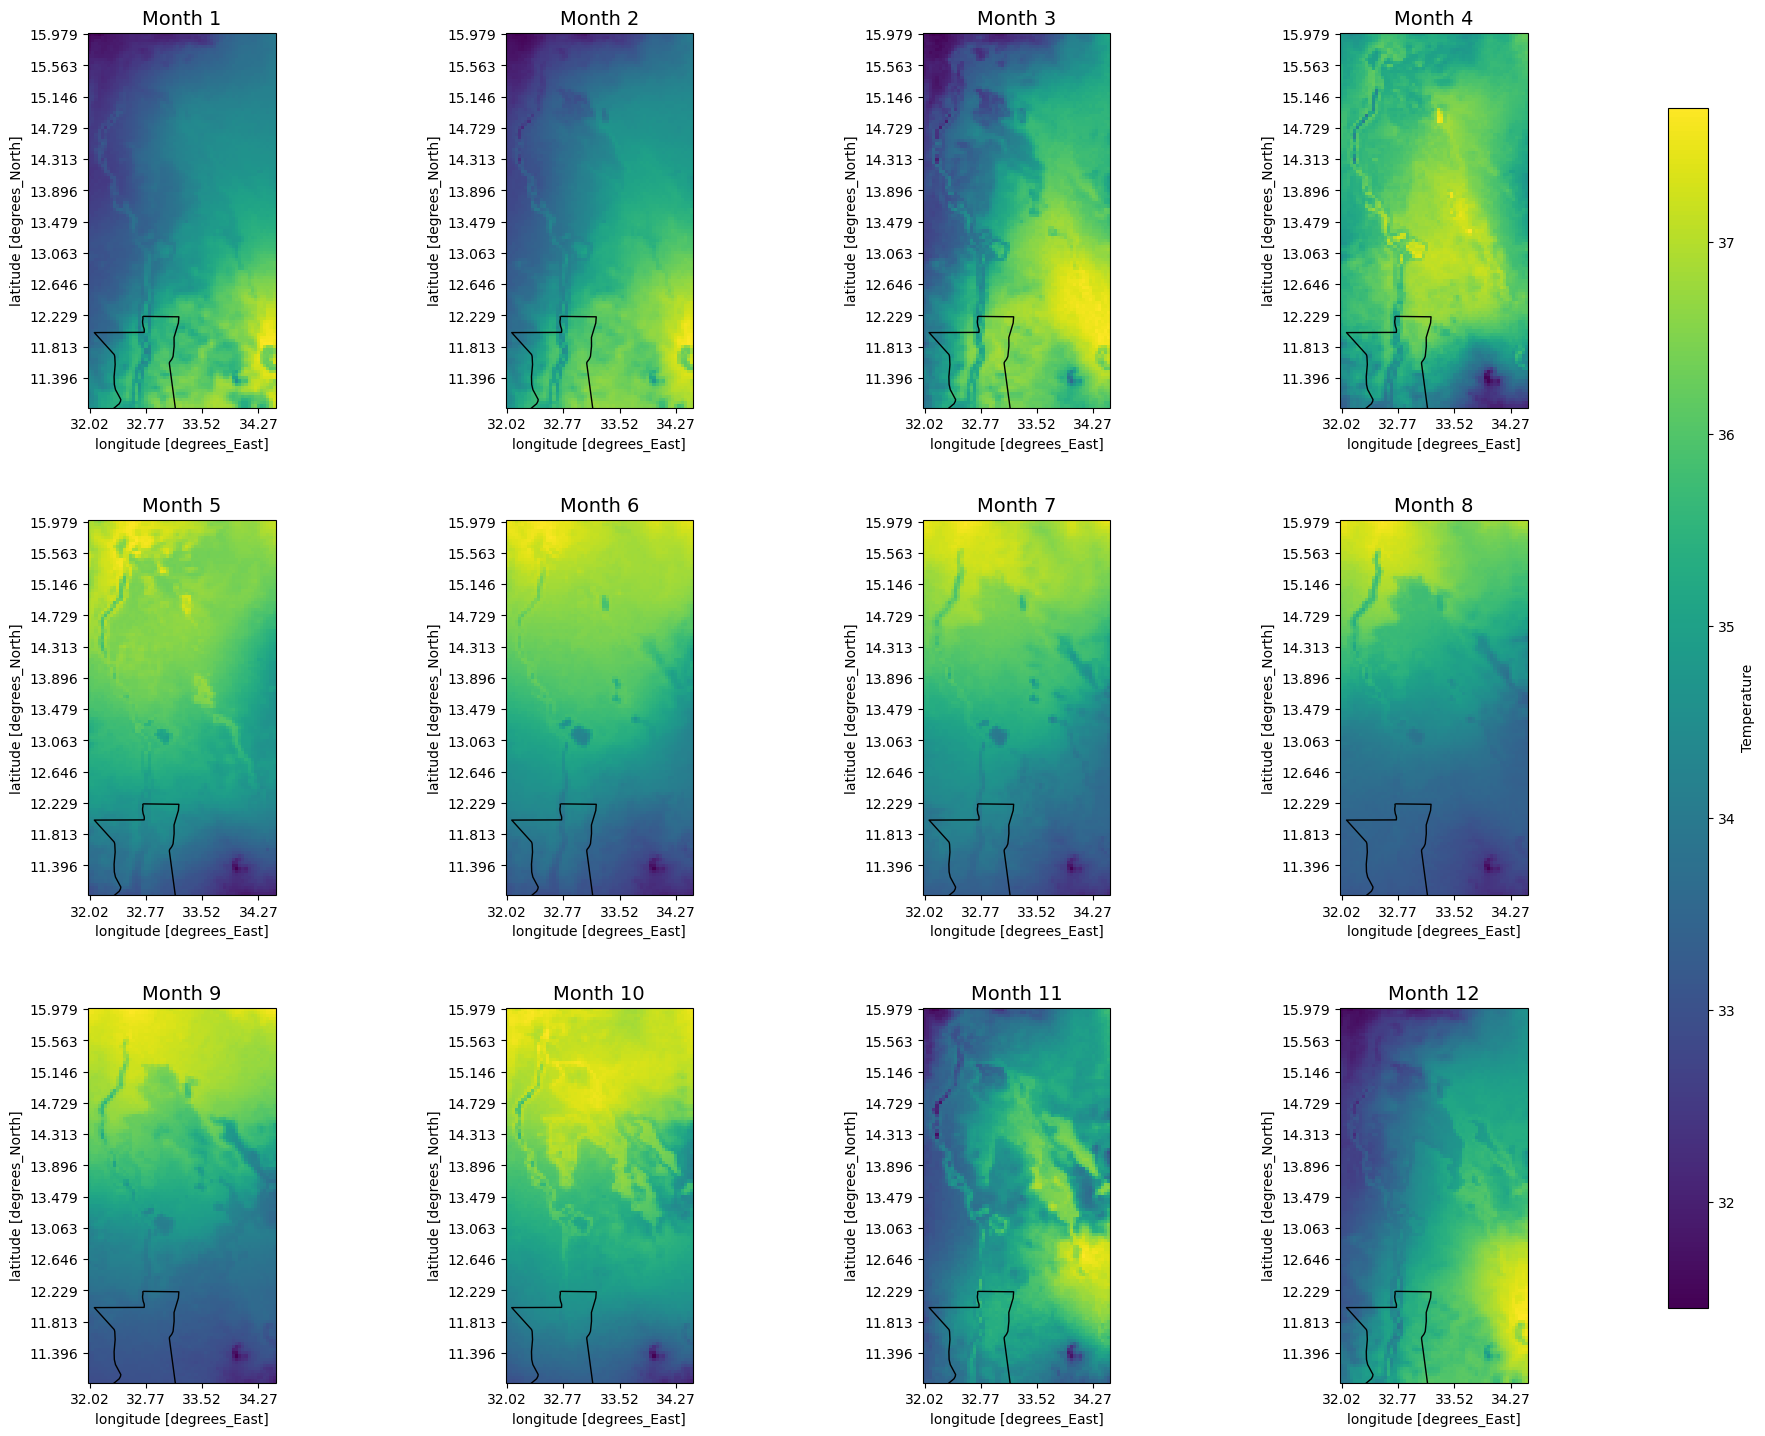

In [106]:
# Define the number of rows and columns
num_rows = 3
num_cols = 4

# Plotting
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 15), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Loop through the rows and columns
for row in range(num_rows):
    for col in range(num_cols):
        month_index = row * num_cols + col + 1  # Calculate the month index
        if month_index <= 12:  # Ensure that we don't exceed 12 months
            # print(tmax_1980_t[month_index-1].time)
            tmax_month = tmax_1980_t[month_index - 1]
            ax = axs[row, col]  # Get the current axis
            pcm = tmax_month.plot.pcolormesh(ax=ax, add_colorbar=False)
            ax.coastlines()
            ax.set_xticks(tmax_month.lon[::18])
            ax.set_yticks(tmax_month.lat[::10])
            ax.add_feature(cfeature.BORDERS)
            ax.set_title(f"Month {month_index}", fontsize=14)
            ax.set_xlabel("longitude [degrees_East]")
            ax.set_ylabel("latitude [degrees_North]")

# Adjust spacing between subplots
plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05, wspace=0.2, hspace=0.3)

# Add colorbar
cax = fig.add_axes([0.88, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(pcm, cax=cax)
cbar.set_label('Temperature')

plt.show()

In [107]:
# open ERA5 data sample
tmin_1980 = xr.open_dataset("../Data/TerraClimate_Gridded_Obs_Geriza/tmin/TerraClimate.tmin.monthlymean.1980.nc")
tmin_1980

<xarray.Dataset> Size: 347kB
Dimensions:  (crs: 1, lon: 60, lat: 120, time: 12)
Coordinates:
  * crs      (crs) int16 2B 3
  * lon      (lon) float64 480B 32.02 32.06 32.1 32.15 ... 34.4 34.44 34.48
  * lat      (lat) float64 960B 15.98 15.94 15.9 15.85 ... 11.1 11.06 11.02
  * time     (time) datetime64[ns] 96B 1980-01-01 1980-02-01 ... 1980-12-01
Data variables:
    tmin     (time, lat, lon) float32 346kB ...
Attributes: (12/49)
    method:                          These layers from TerraClimate were crea...
    title:                           TerraClimate: monthly climate and climat...
    summary:                         This archive contains a dataset of high-...
    keywords:                        WORLDCLIM,global,monthly, temperature,pr...
    id:                              Blank
    naming_authority:                edu.uidaho.nkn
    ...                              ...
    geospatial_vertical_resolution:  0.0
    geospatial_vertical_positive:    Up
    references:                      Abatzoglou, J.T., S.Z. Dobrowski, S.A. P...
    source:                          WorldClim v2.0 (2.5m), CRU Ts4.0, JRA-55
    version:                         v1.0
    Conventions:                     CF-1.6

In [108]:
# Check the data
tmin_1980.tmin

<xarray.DataArray 'tmin' (time: 12, lat: 120, lon: 60)> Size: 346kB
[86400 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 480B 32.02 32.06 32.1 32.15 ... 34.4 34.44 34.48
  * lat      (lat) float64 960B 15.98 15.94 15.9 15.85 ... 11.1 11.06 11.02
  * time     (time) datetime64[ns] 96B 1980-01-01 1980-02-01 ... 1980-12-01
Attributes:
    units:              degC
    description:        Minimum 2-m Temperature
    long_name:          air_temperature
    standard_name:      air_temperature
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326
    _ChunkSizes:        [   1  720 1440]

In [109]:
tmin_1980_t = tmin_1980["tmin"]
tmin_1980_t

<xarray.DataArray 'tmin' (time: 12, lat: 120, lon: 60)> Size: 346kB
[86400 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 480B 32.02 32.06 32.1 32.15 ... 34.4 34.44 34.48
  * lat      (lat) float64 960B 15.98 15.94 15.9 15.85 ... 11.1 11.06 11.02
  * time     (time) datetime64[ns] 96B 1980-01-01 1980-02-01 ... 1980-12-01
Attributes:
    units:              degC
    description:        Minimum 2-m Temperature
    long_name:          air_temperature
    standard_name:      air_temperature
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326
    _ChunkSizes:        [   1  720 1440]

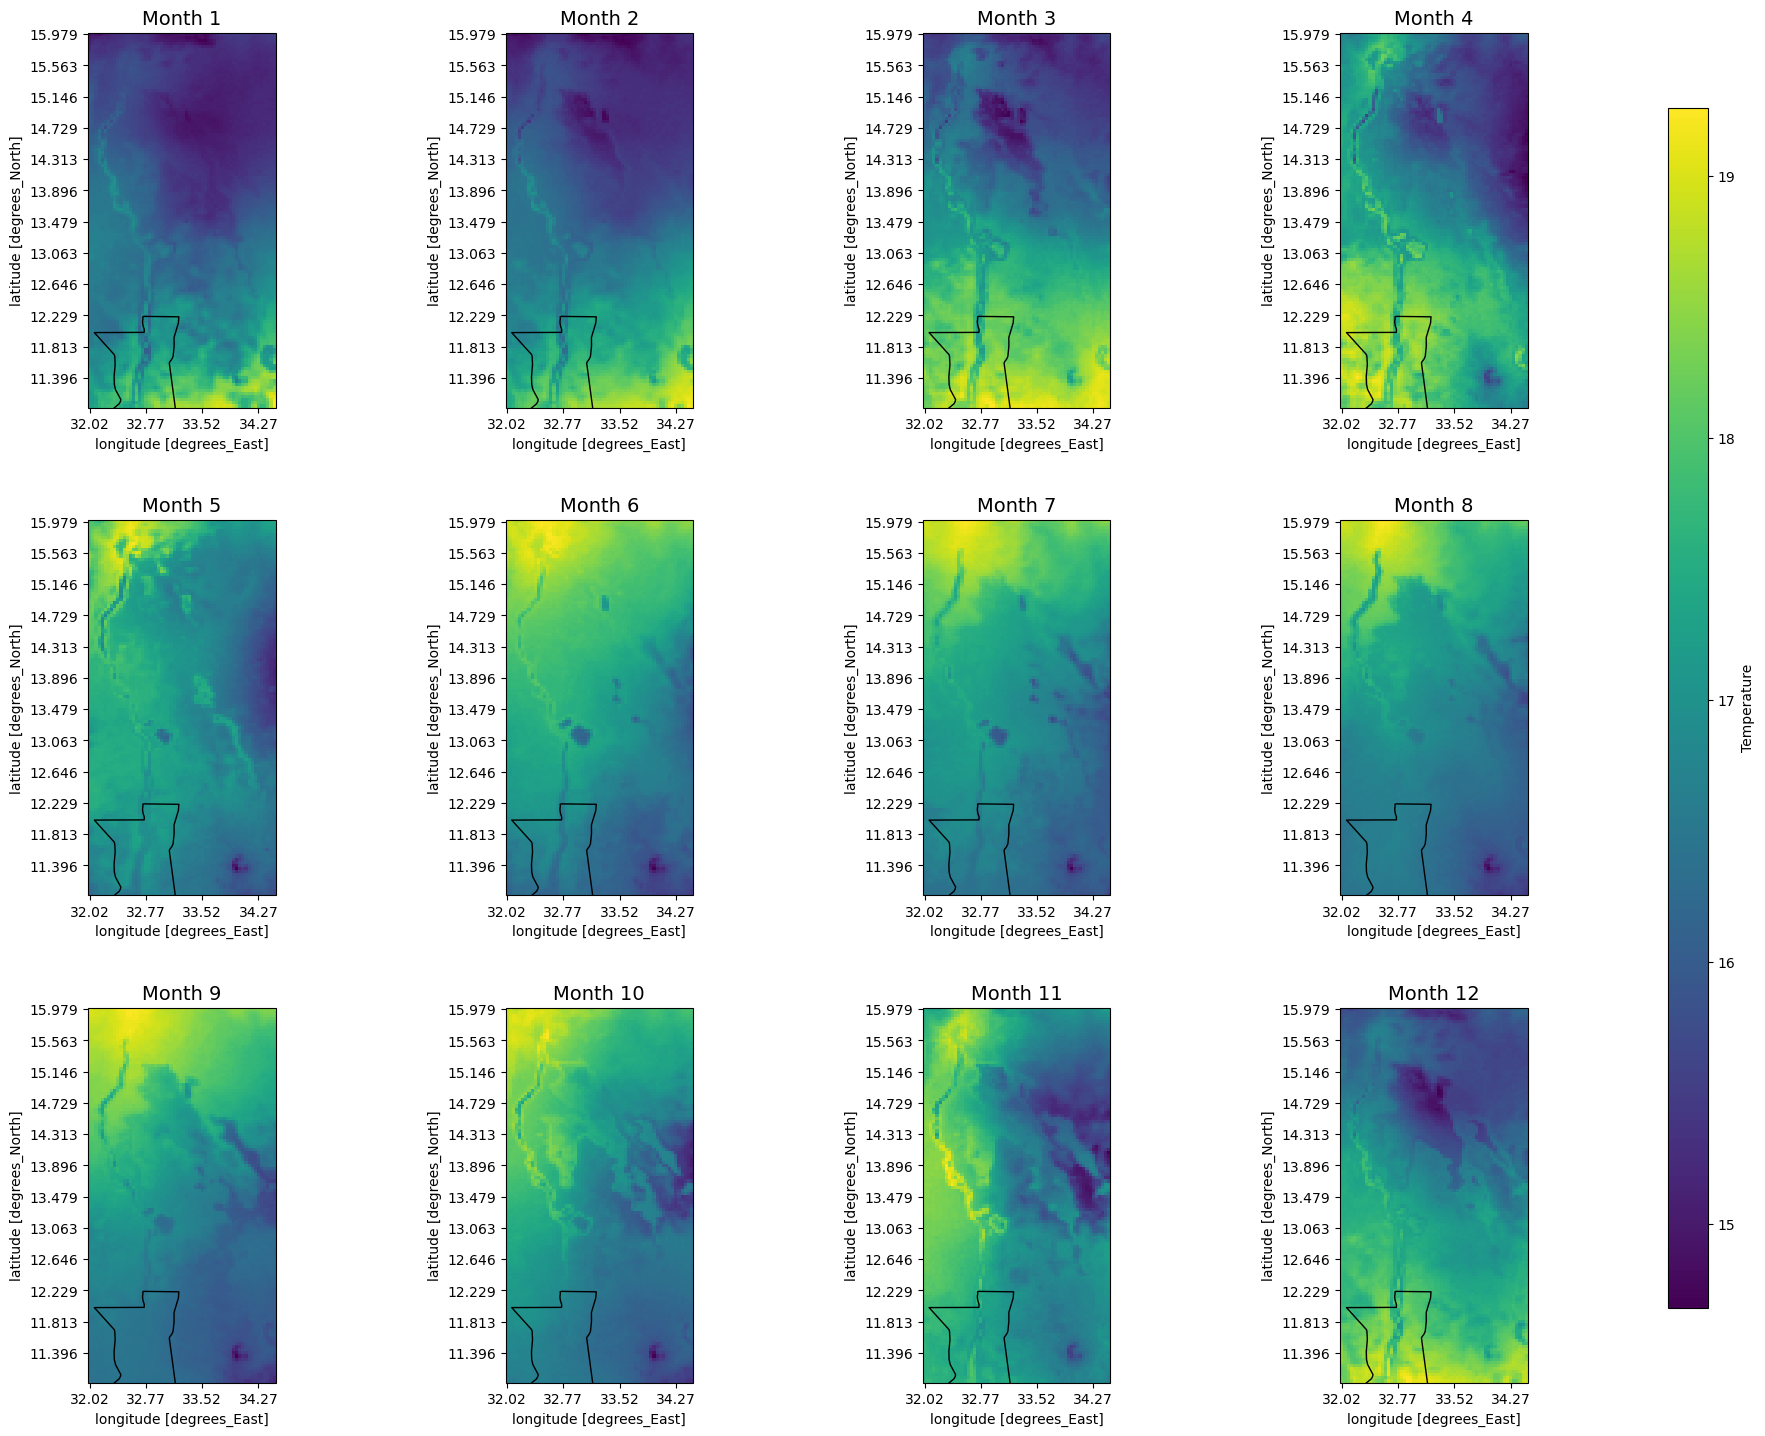

In [110]:
# Define the number of rows and columns
num_rows = 3
num_cols = 4

# Plotting
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 15), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Loop through the rows and columns
for row in range(num_rows):
    for col in range(num_cols):
        month_index = row * num_cols + col + 1  # Calculate the month index
        if month_index <= 12:  # Ensure that we don't exceed 12 months
            tmin_month = tmin_1980_t[month_index - 1]
            ax = axs[row, col]  # Get the current axis
            pcm = tmin_month.plot.pcolormesh(ax=ax, add_colorbar=False)
            ax.coastlines()
            ax.set_xticks(tmin_month.lon[::18])
            ax.set_yticks(tmin_month.lat[::10])
            ax.add_feature(cfeature.BORDERS)
            ax.set_title(f"Month {month_index}", fontsize=14)
            ax.set_xlabel("longitude [degrees_East]")
            ax.set_ylabel("latitude [degrees_North]")

# Adjust spacing between subplots
plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05, wspace=0.2, hspace=0.3)

# Add colorbar
cax = fig.add_axes([0.88, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(pcm, cax=cax)
cbar.set_label('Temperature')

plt.show()

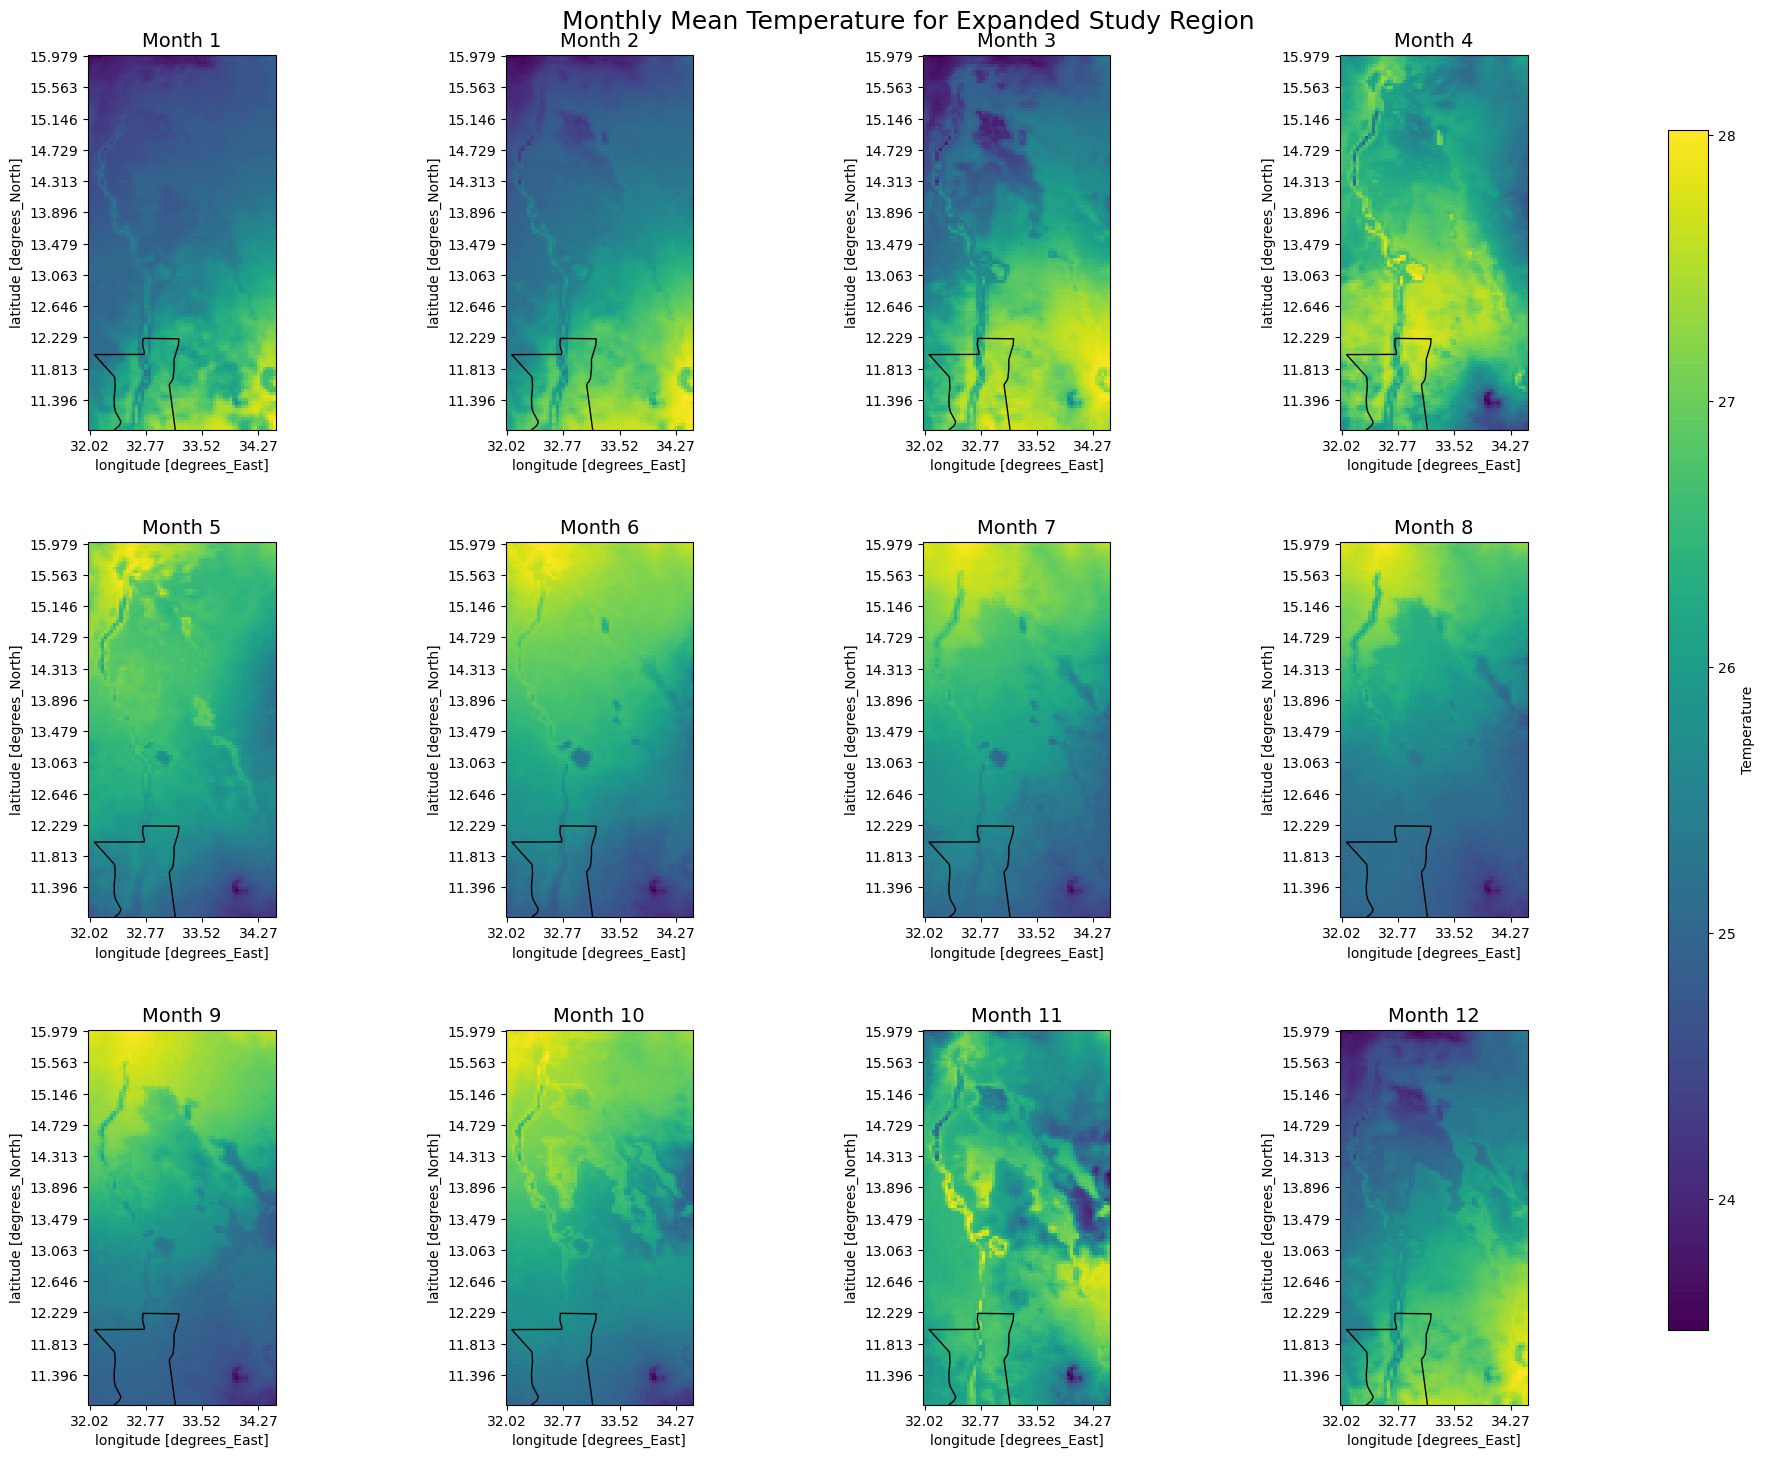

In [117]:
# Define the number of rows and columns
num_rows = 3
num_cols = 4

# Plotting
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 15), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Loop through the rows and columns
for row in range(num_rows):
    for col in range(num_cols):
        month_index = row * num_cols + col + 1  # Calculate the month index
        if month_index <= 12:  # Ensure that we don't exceed 12 months
            # Calculate the mean temperature
            tmean_month = (tmax_1980_t[month_index - 1] + tmin_1980_t[month_index - 1])/2
            ax = axs[row, col]  # Get the current axis
            pcm = tmean_month.plot.pcolormesh(ax=ax, add_colorbar=False)
            ax.coastlines()
            ax.set_xticks(tmean_month.lon[::18])
            ax.set_yticks(tmean_month.lat[::10])
            ax.add_feature(cfeature.BORDERS)
            ax.set_title(f"Month {month_index}", fontsize=14)
            ax.set_xlabel("longitude [degrees_East]")
            ax.set_ylabel("latitude [degrees_North]")

# Adjust spacing between subplots
plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05, wspace=0.2, hspace=0.3)

# Add super title
fig.suptitle("Monthly Mean Temperature for Expanded Study Region", fontsize=18)

# Add colorbar
cax = fig.add_axes([0.88, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(pcm, cax=cax)
cbar.set_label('Temperature')

plt.show()

## 2. Use the Buck equation to find Saturated water vapour pressure

$P = 0.61121exp((18.678-\frac{T}{234.5})(\frac{T}{257.14+T}))$

ddd

In [112]:
# open ERA5 data sample
precip_1980 = xr.open_dataset("../Data/TerraClimate_Gridded_Obs_Geriza/precip/TerraClimate.precip.monthly.1980.nc")
precip_1980

<xarray.Dataset> Size: 693kB
Dimensions:  (crs: 1, lon: 60, lat: 120, time: 12)
Coordinates:
  * crs      (crs) int16 2B 3
  * lon      (lon) float64 480B 32.02 32.06 32.1 32.15 ... 34.4 34.44 34.48
  * lat      (lat) float64 960B 15.98 15.94 15.9 15.85 ... 11.1 11.06 11.02
  * time     (time) datetime64[ns] 96B 1980-01-01 1980-02-01 ... 1980-12-01
Data variables:
    ppt      (time, lat, lon) float64 691kB ...
Attributes: (12/49)
    method:                          These layers from TerraClimate were crea...
    title:                           TerraClimate: monthly climate and climat...
    summary:                         This archive contains a dataset of high-...
    keywords:                        WORLDCLIM,global,monthly, temperature,pr...
    id:                              Blank
    naming_authority:                edu.uidaho.nkn
    ...                              ...
    geospatial_vertical_resolution:  0.0
    geospatial_vertical_positive:    Up
    references:                      Abatzoglou, J.T., S.Z. Dobrowski, S.A. P...
    source:                          WorldClim v2.0 (2.5m), CRU Ts4.0, JRA-55
    version:                         v1.0
    Conventions:                     CF-1.6

In [113]:
type(precip_1980)

xarray.core.dataset.Dataset

In [114]:
precip_1980.ppt

<xarray.DataArray 'ppt' (time: 12, lat: 120, lon: 60)> Size: 691kB
[86400 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 480B 32.02 32.06 32.1 32.15 ... 34.4 34.44 34.48
  * lat      (lat) float64 960B 15.98 15.94 15.9 15.85 ... 11.1 11.06 11.02
  * time     (time) datetime64[ns] 96B 1980-01-01 1980-02-01 ... 1980-12-01
Attributes:
    units:              mm
    description:        Accumulated Precipitation
    long_name:          precipitation_amount
    standard_name:      precipitation_amount
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326
    _ChunkSizes:        [   1  540 1080]

In [115]:
# open ERA5 data sample
RH_1980 = xr.open_dataset("../Data/era5_Geriza/RH/e5.RH.1000hPa.daily.1980.nc")
RH_1980

<xarray.Dataset> Size: 341kB
Dimensions:    (time: 366, longitude: 11, latitude: 21)
Coordinates:
  * time       (time) datetime64[ns] 3kB 1980-01-01 1980-01-02 ... 1980-12-31
  * longitude  (longitude) float32 44B 32.0 32.25 32.5 32.75 ... 34.0 34.25 34.5
  * latitude   (latitude) float32 84B 16.0 15.75 15.5 15.25 ... 11.5 11.25 11.0
Data variables:
    r          (time, latitude, longitude) float32 338kB ...

AttributeError: 'DatasetPlotAccessor' object has no attribute 'contourf'

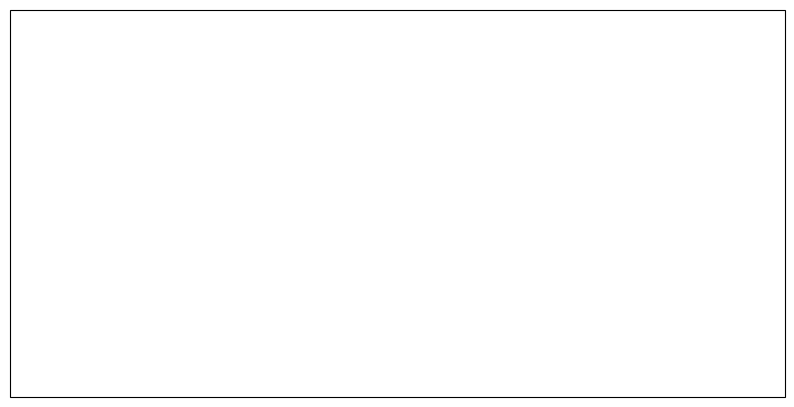

In [116]:
# set up axes with the 'PlateCarree' rectangular coordinate projection for plotting a map
fig, ax = plt.subplots(subplot_kw = dict(projection = ccrs.PlateCarree(), 
                                         transform = ccrs.PlateCarree()),
                       figsize = (10, 6))

# plot the data with 20 filled contours
RH_1980.plot.contourf(ax = ax, 
                      levels = 20, 
                      cbar_kwargs = {'label': 'mm/day', 'orientation': 'horizontal'}
                      )

# add coastlines to the map so we can easily determine what is land and what is not
# (although this dataset only includes data over land so it won't really make much of a difference)
ax.coastlines()

# add provincial borders and make sure they're plotted on top of the contour data
ax.add_feature(cfeature.STATES, zorder = 1)

# plot title
ax.set_title(f"Total Precipitation for 1980")

plt.show()